In [1]:
import os, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Check if CUDA (GPU) is avalible

print('PyTorch %s %s' % 
      (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU')
     )

PyTorch 1.10.2 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)


__1. Create train and holdout folders, where each folder has the three classes as subfolders. Discuss in a markdown cell how many images you chose to have in each class' holdout folder. (Note: you can move images into the folders by hand if you don't want to write a script, but make sure you don't have the same images in train and holdout). Make sure all the class names are the same across folders. Now repeat the process for train and validation, so that you have a train, validation, and holdout folders at the same directory level. Discuss how/why you chose what's in your holdout.__

__Data Loading__

In [3]:
# Image data path for train/validation/holdout

train_path = "D:\\MachineLearning\\dog_image\\train"
val_path = "D:\\MachineLearning\\dog_image\\validation"
holdout_path = "D:\\MachineLearning\\dog_image\\holdout"

In [4]:
# Separate train/validation/holdout set

train = []
valid = []
holdout = []
allpath = [train_path,val_path,holdout_path]

for path in allpath:
    for element in os.listdir(path):
        breed = element
        images = len(os.listdir(os.path.join(path,element)))
        if path == train_path:
            train.append((breed, images))
        elif path == val_path:
            valid.append((breed, images))
        else:
            holdout.append((breed, images))

In [5]:
# train set properties

df_train = pd.DataFrame(train, columns = ['Breed', '#ofImg']) 
print('Total # of image in train set:', df_train['#ofImg'].sum())
df_train.head()

Total # of image in train set: 360


,Breed,#ofImg
0,Great_Dane,105
1,Norfolk_terrier,121
2,Norwich_terrier,134


In [6]:
# validation set properties

df_val = pd.DataFrame(valid, columns = ['Breed', '#ofImg']) 
print('Total # of image in validation set:', df_val['#ofImg'].sum())
df_val.head()

Total # of image in validation set: 51


,Breed,#ofImg
0,Great_Dane,17
1,Norfolk_terrier,17
2,Norwich_terrier,17


In [7]:
# holdout set properties

df_holdout = pd.DataFrame(holdout, columns = ['Breed', '#ofImg']) 
print('Total # of image in holdout set:', df_holdout['#ofImg'].sum())
df_holdout.head()

Total # of image in holdout set: 102


,Breed,#ofImg
0,Great_Dane,34
1,Norfolk_terrier,34
2,Norwich_terrier,34


The train, validation, and holdout folders are at the same directory level, as can be seen in the path above. I have chosen 34 images from each breeds to be the holdout set (approximately 20% of total dataset), 17 images from each breeds in train set to be the validation set (approximately 10% of total dataset). All images are selected randomly.

__2. Define a list of image transformations to be used during training, passing them to transforms.Compose(). Discuss why you think these transformations might help.__ <br> <br>
__3. Repeat the step above for test and validation transformations.__

__Define transform__

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# train transform rule

train_transform = transforms.Compose([
                                     transforms.RandomRotation(degrees=45),
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                     transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(torch.Tensor(mean),
                                                          torch.Tensor(std))])
# validation transform rule

val_transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(torch.Tensor(mean),
                                                         torch.Tensor(std))])
# holdout transform rule

holdout_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

For train_transform, a random roation within 45 degree can simulate dog turning head; a colorjitter to change brightness, contrast and saturation of the image for augmentation; resize to 224x224 to satisfy ImgNet; random horizontal flip also for augmentation; and convert to tensor file and normalize at last.  

For validation and holdout set, only resize to 224x224 is applied, as they are used for testing the model created.

__4. Correctly set up DataLoaders for the three folders (train, validation, holdout). Discuss what options you chose for these loaders, and why (including batch size, shuffling, and dropping last).__

__Setting up DataLoaders__

In [9]:
# Apply transforms

training_set = datasets.ImageFolder(root=train_path, transform=train_transform)
validation_set = datasets.ImageFolder(root=val_path, transform=val_transform)
test_set = datasets.ImageFolder(root=holdout_path, transform=holdout_transform)

# Set up DataLoaders

# since the validation and testing set images number is small, a batch_size of 20 is more reasonable (to have at least 2 to 3 batches).
batch_size = 20

# num_workers is the threads for multi_process data loading (to improve efficiency).
threads = 4

training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True, pin_memory=True)
validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True, pin_memory=True)
test_set_loader = DataLoader(test_set, batch_size=batch_size, num_workers=threads, shuffle=False, pin_memory=True)

# drop_last is set to default (False), which is because the data is so limited that we need them to be included.

__5. Instantiate any pre-trained ImageNet model. Discuss why you chose it amongst the others.__<br><br>
__6. Write code to freeze/unfreeze the pretrained model layers.__

In [10]:
ImgNet_model = resnet.resnet152(pretrained=True)
# Choosing ResNet152 as it has best accuracy among all ResNet versions (Top-1 error: 21.69, Top-5 error: 5.94)

for child in ImgNet_model.named_children():
    print(child)

('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Ba

In [11]:
# Unfreeze "layer4" (which is the "conv5_x" layer, the layer just before the final layer)
# and "fc" (which is the final layer, i.e., the layer for classification)

for name, module in ImgNet_model.named_children():
    if name in ['layer4','fc']:
        print(name + ' is unfrozen')
        for param in module.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in module.parameters():
            param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


__7. Replace the head of the model with sequential layer(s) to predict our three classes.__

In [12]:
# original number of "fc" layer output features
fc_fnum = ImgNet_model.fc.in_features

# replace with sequential laters to predict 3 classes
ImgNet_model.fc = nn.Sequential(nn.Linear(fc_fnum, 256),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(256, 3))


__8. What activation function did you use in the step above? Why?__<br>
I am using ReLU for the activation function of fc layer. First, it is trivial to implement ReLU comparing to activation functions like sigmoid, which makes it faster; secondly, for CNN, ReLU will be useful for regularization, i.e., it is capable of outputting zero value for negative inputs.

__9. Did you use dropout in the step above? Why or why not?__<br>
Yes I did, because it is an effective technique for regularization and preventing the co-adaptation of neurons, as during training, it randomly zeroes some of the elements of the input tensor with a probability (default 0.5 in this case).

__10. Did you use batch normalization in the step above? Why or why not?__<br>
No, at least not for the step above. But yes, if it is asking about the whole model. Because batch normalization is used to help coordinate the update of multiple layers in the model. Whereas in the step above I am only modifying the last layer (the output classification layer). In fact, as shown above, each layer does have batch normalization implemented (bn1, bn2, bn3, for instance)

__11. Choose and instantiate an optimizer. Discuss your choice.__

In [13]:
optimizer = Adam(ImgNet_model.parameters(), lr=0.0001)

# Adam (Adaptive Moment Estimation) has the advantage of converges fast and rapidly, 
# but not too fast that jump over the minimum, (in short, more resonable and better than SGD), 
# but it might be computationlly costly.

__12. Choose and instantiate a loss function. Discuss your choice.__

In [14]:
criterion = nn.CrossEntropyLoss()

# Cross-Entropy loss is used beacuse, here, I am doing a classification of 3 classes

__13. Write code that places the model on the GPU, if it exists, otherwise using the CPU.__

In [15]:
if torch.cuda.is_available():
    print(f'Using {torch.cuda.device_count()} GPUs')
    ImgNet_model.cuda()
else:
    print('Using CPU')

Using 1 GPUs


__14. Correctly set up your model to train over 20+ epochs (if GPU) or 2+ epochs (if CPU).__<br>
__15. Correctly set up your model to use your batches for training.__<br>
__16. Correctly make predictions with your model (the predictions can be wrong).__<br>
__17. Correctly call your loss function and back-propagate its results.__<br>
__18. Use the optimizer correctly to update weights/gradients.__<br>
__19. Correctly record training losses for each epoch.__<br>
__20. Correctly set up validation at each epoch.__<br>
__21. Correctly record validation losses for each epoch.__<br>
__22. Correctly record training and validation accuracies for each epoch.__<br>
__23. Write code that places the model on the GPU, if it exists, otherwise using the CPU.__

In [16]:
# Thanks to @DEWAYNE HALFEN for the idea of the code
# https://www.kaggle.com/code/halfendt/dog-breed-classifier-pytorch-resnet-152

loaders = {'train': training_set_loader, 'val': validation_set_loader}

# For train/validation loss record
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}

# Using GPU [23]
print(f'Using {torch.cuda.device_count()} GPUs')
ImgNet_model.cuda()

start = time.time()

# set 30 epochs
for epoch in range(30):
    for mode in ['train', 'val']:
        if mode == 'train':
            ImgNet_model.train()
        if mode == 'val':
            ImgNet_model.eval()
        
        # initialize loss, accuracy, number of data inputed
        epoch_loss = 0
        epoch_acc = 0
        samples = 0
        
        # training and validation [20]
        # Using batch in dataloders [15]
        for i, (inputs, targets) in enumerate(loaders[mode]):
            # Using CUDA [14]
            inputs = inputs.cuda()
            targets = targets.cuda()

            # initialize optimizer
            optimizer.zero_grad()
            # make predictions using current model [16]
            output = ImgNet_model(inputs)
            # Call loss function [17]
            loss = criterion(output, targets)

            # only update weights when training
            if mode == 'train':
                # back propagation [17]
                loss.backward()
                # Use optimizer to update weights/gradients [18]
                optimizer.step()
                
            # current model accuracy
            acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())

            # record training loss for each epoch [19]
            epoch_loss += loss.data.item()*inputs.shape[0]
            # record training accuracy for each epoch
            epoch_acc += acc*inputs.shape[0]
            # current samples that been inputed
            samples += inputs.shape[0]
            
            # print every 5 iterations
            if i % 5 == 0:
                print(f'[{mode}] Epoch {epoch+1}/{30} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
        
        # After all batches finished
        
        epoch_loss /= samples
        epoch_acc /= samples
        
        # record loss [21, 22]
        losses[mode].append(epoch_loss)
        accuracies[mode].append(epoch_acc)
        
        # print train and validation loss, accuracy
        print(f'[{mode}] Epoch {epoch+1}/{30} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

print(f'Training time: {(time.time()-start)/60:0.2f} min.')

Using 1 GPUs
[train] Epoch 1/30 Iteration 1/18 Loss: 1.13 Accuracy: 0.30
[train] Epoch 1/30 Iteration 6/18 Loss: 1.01 Accuracy: 0.44
[train] Epoch 1/30 Iteration 11/18 Loss: 0.89 Accuracy: 0.60
[train] Epoch 1/30 Iteration 16/18 Loss: 0.77 Accuracy: 0.69
[train] Epoch 1/30 Iteration 18/18 Loss: 0.74 Accuracy: 0.71
[val] Epoch 1/30 Iteration 1/3 Loss: 0.38 Accuracy: 0.80
[val] Epoch 1/30 Iteration 3/3 Loss: 0.28 Accuracy: 0.88
[train] Epoch 2/30 Iteration 1/18 Loss: 0.45 Accuracy: 0.85
[train] Epoch 2/30 Iteration 6/18 Loss: 0.40 Accuracy: 0.87
[train] Epoch 2/30 Iteration 11/18 Loss: 0.35 Accuracy: 0.90
[train] Epoch 2/30 Iteration 16/18 Loss: 0.32 Accuracy: 0.90
[train] Epoch 2/30 Iteration 18/18 Loss: 0.32 Accuracy: 0.90
[val] Epoch 2/30 Iteration 1/3 Loss: 0.04 Accuracy: 1.00
[val] Epoch 2/30 Iteration 3/3 Loss: 0.22 Accuracy: 0.92
[train] Epoch 3/30 Iteration 1/18 Loss: 0.11 Accuracy: 1.00
[train] Epoch 3/30 Iteration 6/18 Loss: 0.16 Accuracy: 0.97
[train] Epoch 3/30 Iteration 11/1

[train] Epoch 20/30 Iteration 18/18 Loss: 0.05 Accuracy: 0.98
[val] Epoch 20/30 Iteration 1/3 Loss: 0.32 Accuracy: 0.95
[val] Epoch 20/30 Iteration 3/3 Loss: 0.50 Accuracy: 0.88
[train] Epoch 21/30 Iteration 1/18 Loss: 0.02 Accuracy: 1.00
[train] Epoch 21/30 Iteration 6/18 Loss: 0.04 Accuracy: 0.98
[train] Epoch 21/30 Iteration 11/18 Loss: 0.07 Accuracy: 0.99
[train] Epoch 21/30 Iteration 16/18 Loss: 0.11 Accuracy: 0.97
[train] Epoch 21/30 Iteration 18/18 Loss: 0.11 Accuracy: 0.97
[val] Epoch 21/30 Iteration 1/3 Loss: 0.03 Accuracy: 1.00
[val] Epoch 21/30 Iteration 3/3 Loss: 0.34 Accuracy: 0.90
[train] Epoch 22/30 Iteration 1/18 Loss: 0.05 Accuracy: 1.00
[train] Epoch 22/30 Iteration 6/18 Loss: 0.07 Accuracy: 0.98
[train] Epoch 22/30 Iteration 11/18 Loss: 0.04 Accuracy: 0.99
[train] Epoch 22/30 Iteration 16/18 Loss: 0.05 Accuracy: 0.98
[train] Epoch 22/30 Iteration 18/18 Loss: 0.05 Accuracy: 0.98
[val] Epoch 22/30 Iteration 1/3 Loss: 0.21 Accuracy: 0.95
[val] Epoch 22/30 Iteration 3/3 

__24. Graph training versus validation loss using matplotlib.pyplot (or other). Was your model overfitting, underfitting, or neither?__

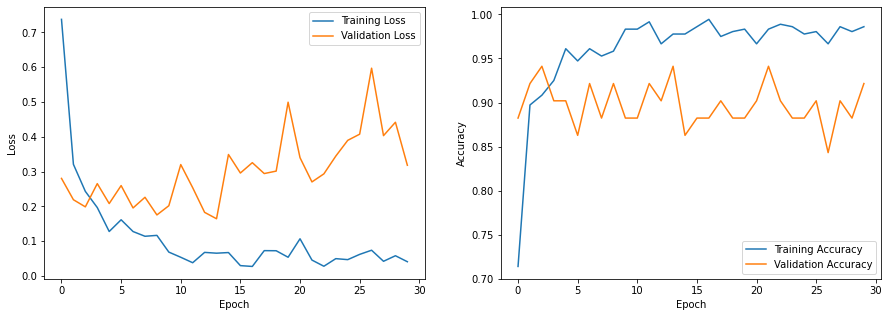

In [17]:
training_loss = losses['train']
training_acc = accuracies['train']
validation_loss = losses['val']
validation_acc = accuracies['val']

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.subplot(122)
plt.plot(training_acc)
plt.plot(validation_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

From the result above, I think the model is overfitting, as the training loss keep decreasing, but validation loss is fluctuating.

__25. Make a list of reasons why your model may have under-performed.__

1. Limited dataset, the number of image is only around 500.
2. Too many epochs, the model may converge early, and thus the rest of epochs only leads to overfitting.
3. only "layer4" and "fc" layers are unfrozen, other layers may also need to update.

__26. Make a list of ways you could improve your model performance (you don't have to implement these unless you wan to).__

1. using scheduler to control the learning rate of the model after each epoch, depends on the loss calculated.
2. implement an early stop when the loss won't decrease for a number of epochs.
3. unfreeze more layers for back propagation.

__27. Graph training versus validation accuracy using matplotlib.pyplot (or other). Score your model on its predictions on the holdout. Discuss why you think your results will or will not generalize.__<br>
See the graph above on the right.

In [18]:
predictions = []
classifications = []

with torch.no_grad():
    ImgNet_model.eval()
    
    for i, batch in enumerate(test_set_loader):
        img, label = batch
        img, label = img.cuda(), label.cuda()
        output = ImgNet_model(img)
        output = output.detach().cpu().numpy()
        predictions.extend(np.argmax(output, 1))
        classifications.extend(label.cpu().numpy())

score = accuracy_score(predictions, classifications)
print('Accuracy on holdout dataset : {:.2%}'.format(score))

Accuracy on holdout dataset : 86.27%


In [21]:
torch.save(ImgNet_model, 'D:\\MachineLearning\\ImgModel.pth')

Even though the dataset is limited, and overfitting during training, the accuracy is actually good (aprox. 90%). So it may be a good model and the result will generalize.

__Discuss the paper in one paragraph.__

It is interesting to know that this Stanford Dogs Dataset is actually challenging for machine learning. As there is inter-class, intra-class variations, plus the images of dogs includes different ages, poses. And I also noticed that a large portion of the images have people on them. These all contribute to the noise when training.